# SentencePiece

## Rubric
1. SentencePiece를 이용하여 모델을 만들기까지의 과정이 정상적으로 진행되었는가?	
코퍼스 분석, 전처리, SentencePiece 적용, 토크나이저 구현 및 동작이 빠짐없이 진행되었는가?
2. SentencePiece를 통해 만든 Tokenizer가 자연어처리 모델과 결합하여 동작하는가?	
SentencePiece 토크나이저가 적용된 Text Classifier 모델이 정상적으로 수렴하여 80% 이상의 test accuracy가 확인되었다.
3. SentencePiece의 성능을 다각도로 비교분석하였는가?	
SentencePiece 토크나이저를 활용했을 때의 성능을 다른 토크나이저 혹은 SentencePiece의 다른 옵션의 경우와 비교하여 분석을 체계적으로 진행하였다.


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib as plt
import konlpy


In [2]:
import pandas as pd
import sentencepiece as spm
import urllib.request
import csv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

## Data - Naver movie review (Korean Corpus)

### Download, Corpus analysis

In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

('ratings.txt', <http.client.HTTPMessage at 0x7fc250d72580>)

In [4]:
df = pd.read_table('ratings.txt') 

# label이 0인 데이터 중 상위 3개 선택
label_0 = df[df['label'] == 0].head(3)

# label이 1인 데이터 중 상위 3개 선택
label_1 = df[df['label'] == 1].head(3)

# 두 데이터프레임을 합치기
result = pd.concat([label_1, label_0])

result

# 3 columns: 'id', 'document', 'label'
# 2 labels: '0 : negative', '1 : positive'
# 100000 positives, 100000 negatives

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
100000,6826470,이런영화로 관객들한테 돈벌고싶소?,0
100001,6239594,작품 선구안이 없다는게 배우 김태희의 최대 약점.,0
100002,8946612,사극?? 로멘스?? 퓨젼??,0


In [5]:
print(len(df))

200000


In [6]:
df.isnull().sum()

# 8 missing documents

id          0
document    8
label       0
dtype: int64

### Preprocess

In [7]:
df = df.dropna(how='any')
print(df.isnull().sum)

<bound method NDFrame._add_numeric_operations.<locals>.sum of            id  document  label
0       False     False  False
1       False     False  False
2       False     False  False
3       False     False  False
4       False     False  False
...       ...       ...    ...
199995  False     False  False
199996  False     False  False
199997  False     False  False
199998  False     False  False
199999  False     False  False

[199992 rows x 3 columns]>


In [8]:
cleaned_corpus = df.drop_duplicates(['document'])   

In [9]:
print('중복 제거 후 데이터 개수 :', len(cleaned_corpus))

중복 제거 후 데이터 개수 : 194543


In [10]:
print('전처리 전 데이터 개수 : 200000')
print('전처리 후 데이터 개수 :', len(cleaned_corpus)) 
print('전처리 후 남은 데이터 양(%)', (len(cleaned_corpus)/200000)*100)

전처리 전 데이터 개수 : 200000
전처리 후 데이터 개수 : 194543
전처리 후 남은 데이터 양(%) 97.2715


In [11]:
print('전처리 후 긍정 데이터: ', len(cleaned_corpus[cleaned_corpus['label'] == 1]))
print('전처리 후 부정 데이터: ', len(cleaned_corpus[cleaned_corpus['label'] == 0]))

# (negative data - positive data) = 11 <- negelectable difference

전처리 후 긍정 데이터:  97266
전처리 후 부정 데이터:  97277


## Corpus length preprocess

In [12]:
review = cleaned_corpus['document']

In [13]:
review

0                                       어릴때보고 지금다시봐도 재밌어요ㅋㅋ
1         디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...
2                      폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.
3         와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...
4                               안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.
                                ...                        
199995                                       포켓 몬스터 짜가 ㅡㅡ;;
199996                                                쓰.레.기
199997                    완전 사이코영화. 마지막은 더욱더 이 영화의질을 떨어트린다.
199998                  왜난 재미없었지 ㅠㅠ 라따뚜이 보고나서 스머프 봐서 그런가 ㅋㅋ
199999                                      포풍저그가나가신다영차영차영차
Name: document, Length: 194543, dtype: object

문장의 최단 길이: 1
문장의 최장 길이: 142
문장의 평균 길이: 36


/tmp/ipykernel_47/3860419660.py:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sentence_length = np.zeros((max_len), dtype=np.int)


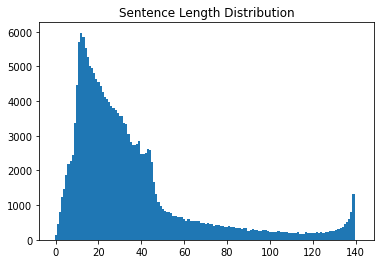

In [14]:
min_len = 999
max_len = 0
sum_len = 0

for sen in review:
    length = len(sen)
    if min_len > length: 
        min_len = length
        
    if max_len < length: 
        max_len = length
    
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(review))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in review:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [15]:
def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return

check_sentence_with_length(review, 1) # check review of length == 1 -> useless == noise

굿
핡
휴
시
ㅋ
ㅇ
‥
O
갑
ㅎ
.
올
헷
g
♥
짱
ㅆ
굳
잼
ㅁ
?
애
흠
!
찜
b
,
1
9
♬
ㅗ
ㄳ
ㄴ
호
a
d
f
음
헐
캬
린
업
乃
ㅠ
;
·
k
움
ㄱ
쩜
-
군
ㅉ
훗
z
쨩
뿌
♡
하
h
ㅍ
꽉
토
귯
아
오
ㅣ
봐
웅
네
ㅂ
꿈
헉
와
뻑
걍
헝
우
즛
풉
4
쀍
ㄹ
삼
쒯
즐
함
0
진
악
풋
쩝
욜
ㄷ
흐
싫
ㅜ
잏
허
엿
쉣


Data Size: 194543
문장의 최단 길이: 1
문장의 최장 길이: 142
문장의 평균 길이: 36
문장의 중간 길이: 27


/tmp/ipykernel_47/882900508.py:29: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sentence_length = np.zeros((max_len), dtype=np.int)


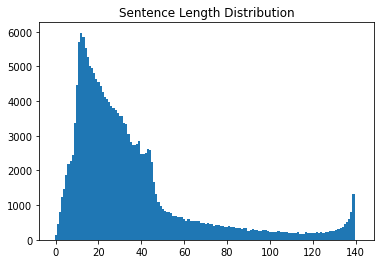

In [16]:
import numpy as np
import matplotlib.pyplot as plt

min_len = 999
max_len = 0
sum_len = 0

# cleaned_corpus = list(set(review))  # set를 사용해서 중복을 제거합니다.
print("Data Size:", len(review)) 

lengths = []  # 문장 길이를 저장할 리스트

for sen in review:
    length = len(sen)
    lengths.append(length)  # 문장 길이를 리스트에 추가
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(review))

# 중간값 계산
sorted_lengths = sorted(lengths)
median = sorted_lengths[len(sorted_lengths) // 2] if len(sorted_lengths) % 2 == 1 else (sorted_lengths[(len(sorted_lengths) - 1) // 2] + sorted_lengths[len(sorted_lengths) // 2]) / 2
print("문장의 중간 길이:", median)

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in review:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()


In [17]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [18]:
below_threshold_len(36, review)  
below_threshold_len(142, review)   
below_threshold_len(27, review) 
below_threshold_len(50, review)  
below_threshold_len(70, review)  


전체 샘플 중 길이가 36 이하인 샘플의 비율: 66.08616090016089
전체 샘플 중 길이가 142 이하인 샘플의 비율: 100.0
전체 샘플 중 길이가 27 이하인 샘플의 비율: 50.20124085677716
전체 샘플 중 길이가 50 이하인 샘플의 비율: 82.05640912291884
전체 샘플 중 길이가 70 이하인 샘플의 비율: 88.66523082300571


/tmp/ipykernel_47/1199963188.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sentence_length = np.zeros((max_len), dtype=np.int)


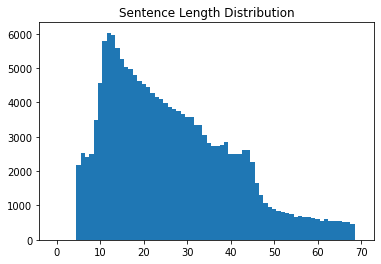

In [19]:
import numpy as np
import matplotlib.pyplot as plt

max_len = 70

# 데이터프레임 조건부 슬라이싱: 문장 길이가 5 이상, max_len 미만인 행만 선택
train_data = df[(df['document'].str.len() < max_len) & (df['document'].str.len() > 5)]

# 분포도를 그립니다.
sentence_length = np.zeros((max_len), dtype=np.int)

for sen in train_data['document']:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()


In [20]:
print('전처리 전 데이터 개수 :', len(df))
print('전처리 후 데이터 개수 :', len(train_data))
print('전처리 후 남은 데이터 양(%)', (len(train_data)/len(df))*100)

전처리 전 데이터 개수 : 199992
전처리 후 데이터 개수 : 169532
전처리 후 남은 데이터 양(%) 84.76939077563102


### Step 1. SentencePiece 설치하기

In [21]:
!pip install sentencepiece

### Step 2. SentencePiece 모델 학습

In [22]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in train_data['document']:   # 이전에 나왔던 정제했던 corpus를 활용해서 진행해야 합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = unigram이 디폴트 적용되어 있습니다. --model_type = bpe로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp --model_prefix=korean_spm --vocab_size=8000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp
  input_format: 
  model_prefix: korean_spm
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id

-rw-r--r-- 1 root root 375117 Aug 15 15:52 korean_spm_8k.model
-rw-r--r-- 1 root root 144553 Aug 15 15:52 korean_spm_8k.vocab
-rw-r--r-- 1 root root 370461 Aug 15 17:32 korean_spm_bpe.model
-rw-r--r-- 1 root root 115663 Aug 15 17:32 korean_spm_bpe.vocab
-rw-r--r-- 1 root root 375114 Aug 16 03:18 korean_spm.model
-rw-r--r-- 1 root root 144553 Aug 16 03:18 korean_spm.vocab


In [23]:
vocab_list = pd.read_csv('korean_spm.vocab', sep='\t', header=None, quoting=csv.QUOTE_NONE)
vocab_list[:10]

,0,1
0,<unk>,0.00000
1,<s>,0.00000
2,</s>,0.00000
3,▁,-3.28398
4,.,-3.47757
5,..,-4.26398
6,이,-4.42282
7,▁영화,-4.43600
8,...,-4.49564
9,가,-4.71026


In [24]:
print('subword의 개수 :', len(vocab_list))
vocab_list.sample(10)

subword의 개수 : 8000


,0,1
4514,▁아이들과,-10.24600
1642,ᄉ,-9.18543
7050,봇,-10.98840
4352,닷,-10.20010
832,라도,-8.51788
7148,ᄂᄂ,-11.01590
929,▁재밌고,-8.63692
5199,같네요,-10.40720
5435,꿀,-10.47210
5601,▁엄마가,-10.51500


In [25]:
def test_performance(model):
    s = spm.SentencePieceProcessor()
    s.Load(model)

    # SentencePiece를 활용한 sentence -> encoding
    tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
    print(tokensIDs)

    # SentencePiece를 활용한 sentence -> encoded pieces
    print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

    # SentencePiece를 활용한 encoding -> sentence 복원
    print(s.DecodeIds(tokensIDs))

In [26]:
print('korean_spm')
test_performance(model='korean_spm.model')


korean_spm
[1637, 9, 470, 15, 1354, 9, 143, 16, 4]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


### Step 3. Tokenizer 함수 작성

In [27]:
def sp_tokenize(s, corpus, spm):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./{}.vocab".format(spm), 'r') as f: 
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre', maxlen=max_len)

    return tensor, word_index, index_word

In [28]:
s = spm.SentencePieceProcessor()

s.Load('korean_spm.model') 

my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = sp_tokenize(s, my_corpus, 'korean_spm')           
print(tensor)
# pre-paddings & token indexes

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0  500 3371   14 1182 2776    4]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0 1631 2133  232  587    9    3   17 7940  819    8]]


### Step 4. 네이버 영화리뷰 감정 분석 문제에 SentencePiece 적용해 보기

In [29]:
tensor, word_index, index_word = sp_tokenize(s, train_data['document'], 'korean_spm')

In [30]:
from sklearn.model_selection import train_test_split

filtered_label = np.array(train_data['label'])
x_train, x_temp, y_train, y_temp = train_test_split(tensor, filtered_label, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

# train: 70%, val: 15%, test: 15%

In [31]:
print(len(x_train), len(x_test), len(x_val))
print(len(y_train), len(y_test), len(y_val))

118672 25430 25430
118672 25430 25430


In [32]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense

class LSTMModel(tf.keras.Model):
    def __init__(self, vocab_size, word_vector_dim):
        super(LSTMModel, self).__init__()
        
        self.embedding = Embedding(vocab_size, word_vector_dim)
        self.lstm = LSTM(128)
        self.dense1 = Dense(128, activation='relu') 
        self.dense2 = Dense(1, activation='sigmoid')
        
    def call(self, x):
        x = self.embedding(x)
        x = self.lstm(x)
        x = self.dense1(x)  
        return self.dense2(x)


model_spm = LSTMModel(vocab_size, word_vector_dim = 16)
model_spm.build((None, None)) 
model_spm.summary()


Model: "lstm_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  128000    
_________________________________________________________________
lstm (LSTM)                  multiple                  74240     
_________________________________________________________________
dense (Dense)                multiple                  16512     
_________________________________________________________________
dense_1 (Dense)              multiple                  129       
Total params: 218,881
Trainable params: 218,881
Non-trainable params: 0
_________________________________________________________________


In [33]:
# set early stopping

es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [34]:
model_spm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20
batch_size=64

history_spm = model_spm.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val,y_val),
                    callbacks=es,
                    verbose=1)

Epoch 1/20
1855/1855 [==============================] - 22s 7ms/step - loss: 0.3995 - accuracy: 0.8168 - val_loss: 0.3457 - val_accuracy: 0.8478
Epoch 2/20
1855/1855 [==============================] - 12s 7ms/step - loss: 0.3189 - accuracy: 0.8614 - val_loss: 0.3281 - val_accuracy: 0.8551
Epoch 3/20
1855/1855 [==============================] - 12s 7ms/step - loss: 0.2811 - accuracy: 0.8792 - val_loss: 0.3258 - val_accuracy: 0.8593
Epoch 4/20
1855/1855 [==============================] - 12s 7ms/step - loss: 0.2521 - accuracy: 0.8933 - val_loss: 0.3315 - val_accuracy: 0.8563
Epoch 5/20
1855/1855 [==============================] - 12s 7ms/step - loss: 0.2266 - accuracy: 0.9036 - val_loss: 0.3505 - val_accuracy: 0.8484
Epoch 00005: early stopping


In [35]:
results = model_spm.evaluate(x_test,  y_test, verbose=2)
print('spm acc:', round(results[1] * 100,2), '%' )

795/795 - 2s - loss: 0.3674 - accuracy: 0.8438
spm acc: 84.38 %


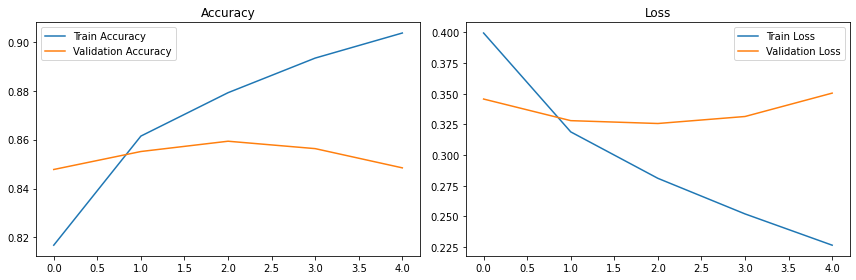

In [36]:
class HistoryPlotter:
    def __init__(self, history):
        self.history = history

    def plot(self):
        # Accuracy
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(self.history.history['accuracy'], label='Train Accuracy')
        plt.plot(self.history.history['val_accuracy'], label='Validation Accuracy')
        plt.legend()
        plt.title('Accuracy')

        # Loss
        plt.subplot(1, 2, 2)
        plt.plot(self.history.history['loss'], label='Train Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.legend()
        plt.title('Loss')

        plt.tight_layout()
        plt.show()


plotter = HistoryPlotter(history_spm)
plotter.plot()

## Use different Tokenizer

### SentencePiece BPE(byte-pair-encoding) mode

In [37]:
spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm_bpe --vocab_size={} --model_type=bpe'.format(temp_file, vocab_size)    
)

!ls -l korean_spm_bpe*

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp --model_prefix=korean_spm_bpe --vocab_size=8000 --model_type=bpe
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp
  input_format: 
  model_prefix: korean_spm_bpe
  model_type: BPE
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_

-rw-r--r-- 1 root root 370461 Aug 16 03:20 korean_spm_bpe.model
-rw-r--r-- 1 root root 115663 Aug 16 03:20 korean_spm_bpe.vocab


In [38]:
vocab_list_bpe = pd.read_csv('korean_spm_bpe.vocab', sep='\t', header=None, quoting=csv.QUOTE_NONE)
vocab_list_bpe[:10]

,0,1
0,<unk>,0
1,<s>,0
2,</s>,0
3,..,0
4,영화,-1
5,▁영화,-2
6,▁이,-3
7,...,-4
8,▁아,-5
9,▁재,-6


In [39]:
print('subword의 개수 :', len(vocab_list_bpe))
vocab_list_bpe.sample(10)

subword의 개수 : 8000


,0,1
7388,쌩,-7385
2980,...?,-2977
7373,헉,-7370
3225,▁신파,-3222
5485,▁오글오글,-5482
1574,▁것을,-1571
4740,▁살고,-4737
1200,▁커,-1197
5130,▁잊지못,-5127
6145,시대에,-6142


In [40]:
print('korean_spm_bpe')
test_performance(model='korean_spm_bpe.model')

korean_spm_bpe
[5824, 934, 6549, 6274, 1525, 6270, 6378, 6264, 6262]
['▁아버', '지가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


In [41]:
s_bpe = spm.SentencePieceProcessor()

s_bpe.Load('korean_spm_bpe.model') 

my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = sp_tokenize(s_bpe, my_corpus, 'korean_spm_bpe')           
print(tensor)

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0  662 3163 6292  555  826 6262]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0 1734 2189  303  339 6270  166 7630   15    7]]


In [42]:
tensor_bpe, word_index_bpe, index_word_bpe = sp_tokenize(s_bpe, train_data['document'], 'korean_spm_bpe')

In [43]:
filtered_label = np.array(train_data['label'])
x_train_bpe, x_temp, y_train_bpe, y_temp = train_test_split(tensor_bpe, filtered_label, test_size=0.3, random_state=42)
x_val_bpe, x_test_bpe, y_val_bpe, y_test_bpe = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)


In [44]:
model_spm_bpe = LSTMModel(vocab_size, word_vector_dim = 16)
model_spm_bpe.build((None, None)) 
model_spm_bpe.summary()

Model: "lstm_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      multiple                  128000    
_________________________________________________________________
lstm_1 (LSTM)                multiple                  74240     
_________________________________________________________________
dense_2 (Dense)              multiple                  16512     
_________________________________________________________________
dense_3 (Dense)              multiple                  129       
Total params: 218,881
Trainable params: 218,881
Non-trainable params: 0
_________________________________________________________________


In [45]:
model_spm_bpe.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20
batch_size=64

history_spm_bpe = model_spm_bpe.fit(x_train_bpe,
                    y_train_bpe,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val_bpe,y_val_bpe),
                    callbacks=es,
                    verbose=1)

Epoch 1/20
1855/1855 [==============================] - 14s 7ms/step - loss: 0.3977 - accuracy: 0.8176 - val_loss: 0.3473 - val_accuracy: 0.8456
Epoch 2/20
1855/1855 [==============================] - 12s 7ms/step - loss: 0.3231 - accuracy: 0.8598 - val_loss: 0.3311 - val_accuracy: 0.8540
Epoch 3/20
1855/1855 [==============================] - 12s 7ms/step - loss: 0.2896 - accuracy: 0.8751 - val_loss: 0.3336 - val_accuracy: 0.8571
Epoch 4/20
1855/1855 [==============================] - 12s 7ms/step - loss: 0.2574 - accuracy: 0.8899 - val_loss: 0.3337 - val_accuracy: 0.8565
Epoch 00004: early stopping


In [46]:
results = model_spm_bpe.evaluate(x_test_bpe,  y_test_bpe, verbose=2)
print('spm_bpe acc:', round(results[1] * 100,2), '%' )

795/795 - 2s - loss: 0.3450 - accuracy: 0.8512
spm_bpe acc: 85.12 %


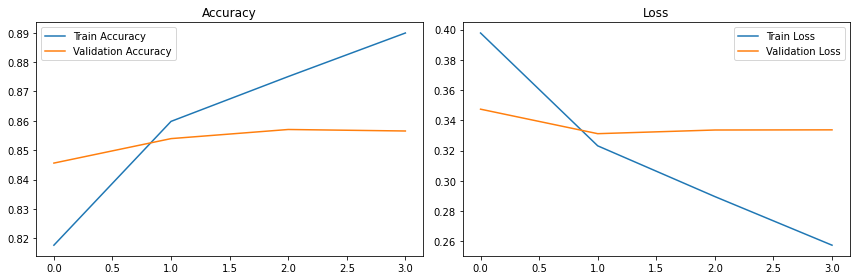

In [47]:
plotter = HistoryPlotter(history_spm_bpe)
plotter.plot()

# Summary

- Dataset: Naver movie review(kor)
- Preprocess:
    - Max_len : 70, Min_len : 5
    - after preprocess : 88.309% left
- Tokenize methods: SentencePiece(unigram, bpe)
    - vocabsize = 8000
- Train, validation, Test = 70 : 15 : 15
- Model: Embedding(16)-Lstm(128)-Dense(128)-Dense(sigmoid)

# Result

Acc & Loss for unigram SentencePiece tokenizer - simple LSTM model


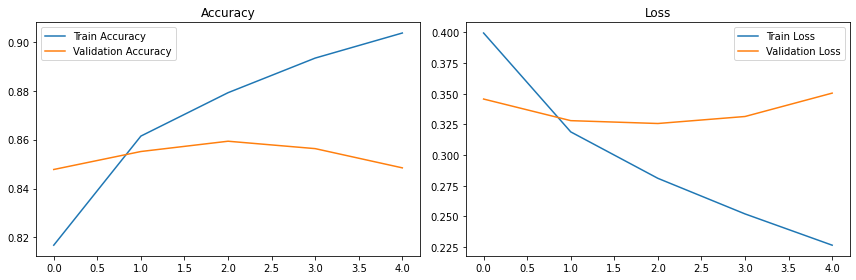

Acc & Loss for byte-pair-encoding SentencePiece tokenizer - simple LSTM model


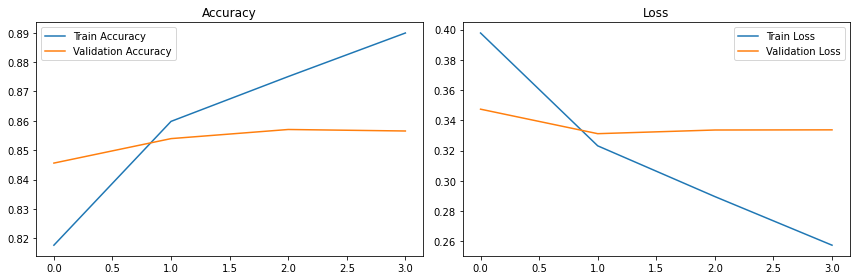

In [48]:
print('Acc & Loss for unigram SentencePiece tokenizer - simple LSTM model')
plotter = HistoryPlotter(history_spm)
plotter.plot()

print('Acc & Loss for byte-pair-encoding SentencePiece tokenizer - simple LSTM model')
plotter = HistoryPlotter(history_spm_bpe)
plotter.plot()

| SentencePiece(Method) | Test-Acc | Best val acc epoch|
|-----------------------|----------|---|
| unigram               | 84.38 %  |2|
| bpe                   | 85.12 %  |1|
